In [2]:

import kagglehub
nisarahmedrana_biq2021_path = kagglehub.dataset_download('nisarahmedrana/biq2021')

print('Data source import complete.')

100%|██████████| 406M/406M [00:04<00:00, 89.6MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kagglehub import dataset_download
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kagglehub import dataset_download

In [4]:
# Step 1: Dataset Download Path
path = dataset_download("nisarahmedrana/BIQ2021")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'biq2021' dataset.
Path to dataset files: /kaggle/input/biq2021


In [5]:
# Step 2: Load Dataset
csv_path = os.path.join(path, "BIQ2021.csv")
df = pd.read_csv(csv_path)

In [6]:
# Prepend the dataset path to image names
df["Images"] = df["Images"].apply(lambda x: os.path.join(path, x))

In [7]:
# Check the DataFrame if it is correctly structured
df.head(5)

,Images,MOS,StandardDeviation
0,/kaggle/input/biq2021/Images (1).jpg,0.138205,0.054030
1,/kaggle/input/biq2021/Images (2).jpg,0.654088,0.318964
2,/kaggle/input/biq2021/Images (3).jpg,0.679017,0.152763
3,/kaggle/input/biq2021/Images (4).jpg,0.442209,0.009709
4,/kaggle/input/biq2021/Images (5).jpg,0.484388,0.135056


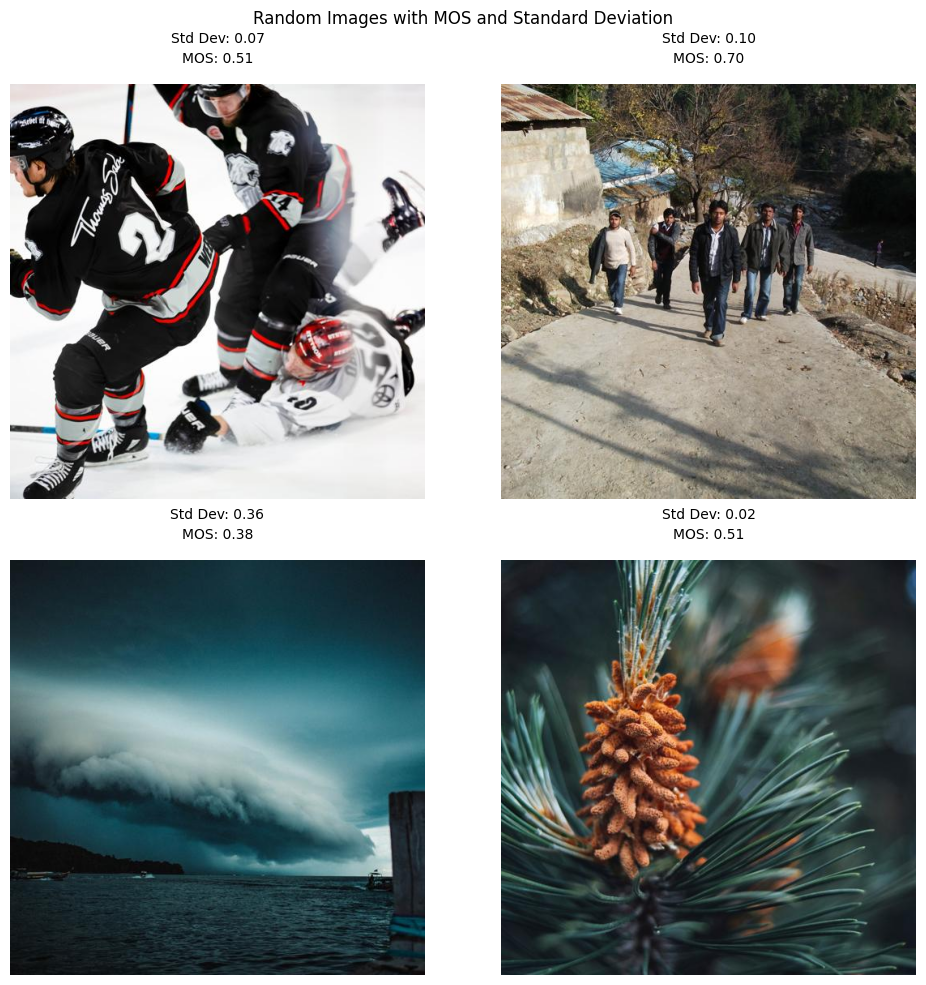

In [8]:
# Plot four random images with their MOS and Std
import matplotlib.image as mpimg
num_images=4
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.suptitle("Random Images with MOS and Standard Deviation")
for i in range(num_images):
    # Select a random row
    random_index = random.randint(0, len(df) - 1)
    row = df.iloc[random_index]

    # Load the image
    img = mpimg.imread(row['Images'])

    # Get the corresponding axes
    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.axis('off')

    # Add MOS and Standard Deviation as text
    mos = f"MOS: {row['MOS']:.2f}"
    std_dev = f"Std Dev: {row['StandardDeviation']:.2f}"
    ax.text(0.5, 1.05, mos, ha='center', transform=ax.transAxes)
    ax.text(0.5, 1.1, std_dev, ha='center', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [9]:
# Extract image paths and MOS labels
image_paths = df["Images"].values
mos_labels = df["MOS"].values

In [10]:
# Normalize MOS labels
scaler = MinMaxScaler()
image_paths = df["Images"].values  # Extract image paths
mos_labels = df["MOS"].values      # Extract MOS labels
mos_labels = scaler.fit_transform(mos_labels.reshape(-1, 1))


In [11]:
# Step 3: Train-Test-Validation Split
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, mos_labels, test_size=0.2, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42)

In [12]:
# Step 4: Data Preprocessing
image_size = (224, 224)

In [13]:
# Function to load and preprocess images
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

In [14]:
# Data generators for efficiency
def data_generator(paths, labels, batch_size):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            images = np.array([preprocess_image(path) for path in batch_paths])
            yield images, np.array(batch_labels)

batch_size = 32

In [15]:
base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
base_model.trainable = True   # fine-tune entire network; you can freeze some initial layers if desired
LEARNING_RATE = 5e-4
inputs = layers.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)   # ensure same preproc
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='linear')(x)   # regression output
model = models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,323,905 (69.90 MB)

 Trainable params: 18,094,849 (69.03 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [16]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

In [18]:
# Step 6: Train Model
train_steps = len(train_paths) // batch_size
val_steps = len(val_paths) // batch_size

train_gen = data_generator(train_paths, train_labels, batch_size)
val_gen = data_generator(val_paths, val_labels, batch_size)
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3142s 10s/step - loss: 0.1656 - mae: 0.3023 - val_loss: 0.0246 - val_mae: 0.1248
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2991s 10s/step - loss: 0.0294 - mae: 0.1368 - val_loss: 0.0228 - val_mae: 0.1201
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3076s 10s/step - loss: 0.0262 - mae: 0.1296 - val_loss: 0.0221 - val_mae: 0.1189
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3084s 10s/step - loss: 0.0255 - mae: 0.1274 - val_loss: 0.0216 - val_mae: 0.1180
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3075s 10s/step - loss: 0.0247 - mae: 0.1259 - val_loss: 0.0215 - val_mae: 0.1182
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3041s 10s/step - loss: 0.0246 - mae: 0.1258 - val_loss: 0.0215 - val_mae: 0.1182
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3041s 10s/step - loss: 0.0246 - mae: 0.1249 - val_loss: 0.0221 - val_mae: 0.1203
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2959s 10s/step - loss: 0.0247 - mae: 0.1261 - val_loss: 0.0219 - val_mae: 0.1197
Epoch 9/10
300/300 ━━━━━━━━━━━━━

In [19]:
# Step 7: Evaluate Model
test_steps = len(test_paths) // batch_size
test_gen = data_generator(test_paths, test_labels, batch_size)
results = model.evaluate(test_gen, steps=test_steps)

print("Loss (MSE):", results[0])
print("MAE:", results[1])

37/37 ━━━━━━━━━━━━━━━━━━━━ 350s 9s/step - loss: 0.0221 - mae: 0.1199
Loss (MSE): 0.023234054446220398
MAE: 0.12272591143846512


In [20]:
# Step 8: Save the Model
model.save("Final_Model.keras")

In [30]:
%%writefile Vividvisionai.py

import streamlit as st
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import io
import base64

# Configure Streamlit page
st.set_page_config(
    page_title="Image Quality Analyzer",
    page_icon="🖼️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #1f77b4;
        text-align: center;
        margin-bottom: 2rem;
    }
    .prediction-box {
        padding: 1rem;
        border-radius: 10px;
        margin: 1rem 0;
    }
    .good-quality {
        background-color: #d4edda;
        border: 1px solid #c3e6cb;
        color: #155724;
    }
    .bad-quality {
        background-color: #f8d7da;
        border: 1px solid #f5c6cb;
        color: #721c24;
    }
    .issue-item {
        background-color: #fff3cd;
        border: 1px solid #ffeaa7;
        color: #856404;
        padding: 0.5rem;
        margin: 0.25rem 0;
        border-radius: 5px;
    }
</style>
""", unsafe_allow_html=True)

# Title and description
st.markdown('<h1 class="main-header">🖼️ Image Quality Analyzer</h1>', unsafe_allow_html=True)
st.markdown("""
**Analyze image quality using advanced deep learning techniques!**
Upload single or multiple images to get quality predictions and detailed issue analysis.
""")

# Sidebar for configuration
st.sidebar.header("Configuration")
confidence_threshold = st.sidebar.slider("Quality Threshold", 0.0, 1.0, 0.5, 0.01)


# Load the trained model (with error handling)
@st.cache_resource
def load_trained_model():
    try:
        model = tf.keras.models.load_model("Final_Model.keras")
        return model
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        return None

# Image preprocessing function - FIXED to match your training pipeline
def preprocess_image_for_model(img, target_size=(224, 224)):
    """Preprocess image for the DenseNet model - matches training preprocessing"""
    try:
        # Resize image to model input size
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)

        # Convert to array and preprocess exactly like training
        img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
        # Use the same preprocessing as in training (MobileNetV2 preprocessing was used in training)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        return img_array
    except Exception as e:
        st.error(f"Error preprocessing image: {str(e)}")
        return None

# Issue detection function
def detect_image_issues(image_cv):
    """Detect various quality issues in the image"""
    issues = []

    try:
        gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)

        # Blur detection using Laplacian variance
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 100:
            issues.append(f"Blur detected (sharpness: {laplacian_var:.2f})")

        # Contrast analysis
        contrast = gray.std()
        if contrast < 40:
            issues.append(f"Low contrast (contrast: {contrast:.2f})")

        # Brightness analysis
        brightness = np.mean(gray)
        if brightness < 80:
            issues.append(f"Dark image (brightness: {brightness:.2f})")
        elif brightness > 200:
            issues.append(f"Overexposed (brightness: {brightness:.2f})")

        # Noise detection using standard deviation of Laplacian
        noise_level = cv2.Laplacian(gray, cv2.CV_64F).std()
        if noise_level > 15:
            issues.append(f"📡 High noise level (noise: {noise_level:.2f})")

        # Color distribution analysis
        if len(image_cv.shape) == 3:
            color_std = np.std([np.std(image_cv[:,:,i]) for i in range(3)])
            if color_std < 10:
                issues.append(f"🎨 Poor color distribution (variation: {color_std:.2f})")

        if not issues:
            issues.append("No major quality issues detected")

    except Exception as e:
        issues.append(f"Error analyzing image: {str(e)}")

    return issues

# FIXED Quality classification function - now returns both values
def classify_quality_score(score, threshold=0.5):
    """Classify quality score into categories with icons"""
    if score >= threshold + 0.2:
        return "Excellent", "⭐"
    elif score >= threshold:
        return "Good", "✅"
    elif score >= threshold - 0.2:
        return "Fair", "⚠️"
    else:
        return "Poor", "❌"

# Main application logic
def main():
    model = load_trained_model()

    if model is None:
        st.error("Failed to load the trained model. Please ensure 'Final_Model.keras' exists.")
        return

    # File uploader
    if batch_processing:
        uploaded_files = st.file_uploader(
            "Upload images for quality analysis",
            type=["jpg", "jpeg", "png", "bmp", "tiff"],
            accept_multiple_files=True,
            help="You can upload multiple images for batch processing"
        )
    else:
        uploaded_file = st.file_uploader(
            "Upload an image for quality analysis",
            type=["jpg", "jpeg", "png", "bmp", "tiff"],
            help="Upload a single image for analysis"
        )
        uploaded_files = [uploaded_file] if uploaded_file else []

    if uploaded_files:
        # Filter out None values (empty uploads)
        uploaded_files = [f for f in uploaded_files if f is not None]

        if len(uploaded_files) == 1:
            # Single image analysis
            process_single_image(uploaded_files[0], model, confidence_threshold, show_technical_details)
        elif len(uploaded_files) > 1:
            # Batch processing
            process_multiple_images(uploaded_files, model, confidence_threshold, show_technical_details)

def process_single_image(uploaded_file, model, threshold, show_details):
    """Process and analyze a single image"""
    try:
        # Load and display image
        img = Image.open(uploaded_file).convert("RGB")

        col1, col2 = st.columns([1, 1])

        with col1:
            st.subheader("Uploaded Image")
            st.image(img, caption=f"Original Image: {uploaded_file.name}", use_column_width=True)

            if show_details:
                st.write(f"**Image Size:** {img.size[0]} x {img.size[1]} pixels")
                st.write(f"**File Size:** {len(uploaded_file.getvalue())} bytes")

        with col2:
            st.subheader("Analysis Results")

            # Preprocess and predict
            img_preprocessed = preprocess_image_for_model(img)
            if img_preprocessed is not None:
                with st.spinner("Analyzing image quality..."):
                    prediction = model.predict(img_preprocessed, verbose=0)
                    quality_score = float(prediction[0][0])

                # Classify quality - FIXED: now properly unpacks two values
                quality_class, quality_icon = classify_quality_score(quality_score, threshold)

                # Display prediction results
                quality_class_css = "good-quality" if quality_score >= threshold else "bad-quality"
                st.markdown(f"""
                <div class="prediction-box {quality_class_css}">
                    <h3>{quality_icon} Quality: {quality_class}</h3>
                    <p><strong>Quality Score:</strong> {quality_score:.4f}</p>
                    <p><strong>Confidence:</strong> {abs(quality_score - 0.5) * 2:.2%}</p>
                </div>
                """, unsafe_allow_html=True)

                # Issue detection
                st.subheader("🔧 Detected Issues")
                image_cv = np.array(img)
                issues = detect_image_issues(image_cv)

                for issue in issues:
                    st.markdown(f'<div class="issue-item">{issue}</div>', unsafe_allow_html=True)

                # Technical details
                if show_details:
                    st.subheader("Technical Details")

                    # Create metrics
                    col1_tech, col2_tech = st.columns(2)

                    with col1_tech:
                        gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)
                        st.metric("Brightness", f"{np.mean(gray):.2f}", delta=None)
                        st.metric("Contrast", f"{gray.std():.2f}", delta=None)

                    with col2_tech:
                        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
                        st.metric("Sharpness", f"{laplacian_var:.2f}", delta=None)
                        noise_level = cv2.Laplacian(gray, cv2.CV_64F).std()
                        st.metric("Noise Level", f"{noise_level:.2f}", delta=None)

                    # Histogram
                    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
                    ax.hist(gray.ravel(), bins=256, range=[0, 256], alpha=0.7)
                    ax.set_title("Brightness Distribution")
                    ax.set_xlabel("Pixel Intensity")
                    ax.set_ylabel("Frequency")
                    st.pyplot(fig)
                    plt.close(fig)  # Close figure to free memory

    except Exception as e:
        st.error(f"Error processing image: {str(e)}")
        st.error("Please make sure the image is valid and the model file 'Final_Model.keras' exists.")

def process_multiple_images(uploaded_files, model, threshold, show_details):
    """Process and analyze multiple images"""
    st.subheader(f"Batch Analysis Results ({len(uploaded_files)} images)")

    results = []
    progress_bar = st.progress(0)
    status_text = st.empty()

    for i, uploaded_file in enumerate(uploaded_files):
        try:
            status_text.text(f"Processing {uploaded_file.name}...")

            # Load and process image
            img = Image.open(uploaded_file).convert("RGB")
            img_preprocessed = preprocess_image_for_model(img)

            if img_preprocessed is not None:
                prediction = model.predict(img_preprocessed, verbose=0)
                quality_score = float(prediction[0][0])
                quality_class, quality_icon = classify_quality_score(quality_score, threshold)

                # Detect issues
                image_cv = np.array(img)
                issues = detect_image_issues(image_cv)
                main_issues = [issue for issue in issues if not issue.startswith("✅")]

                results.append({
                    "Image": uploaded_file.name,
                    "Quality Score": quality_score,
                    "Classification": quality_class,
                    "Icon": quality_icon,
                    "Issues": len(main_issues) if main_issues else 0,
                    "Main Issue": main_issues[0] if main_issues else "None",
                    "Image Object": img
                })

            progress_bar.progress((i + 1) / len(uploaded_files))

        except Exception as e:
            st.error(f"Error processing {uploaded_file.name}: {str(e)}")

    status_text.text("Analysis complete!")

    if results:
        # Summary statistics
        col1, col2, col3, col4 = st.columns(4)

        good_images = sum(1 for r in results if r["Quality Score"] >= threshold)
        avg_score = np.mean([r["Quality Score"] for r in results])
        total_issues = sum(r["Issues"] for r in results)

        col1.metric("Total Images", len(results))
        col2.metric("Good Quality", good_images)
        col3.metric("Average Score", f"{avg_score:.3f}")
        col4.metric("Total Issues", total_issues)

        # Results table
        st.subheader("Detailed Results")
        df_results = pd.DataFrame([{
            "Image": r["Image"],
            "Quality": f"{r['Icon']} {r['Classification']}",
            "Score": f"{r['Quality Score']:.4f}",
            "Issues": r["Issues"],
            "Main Issue": r["Main Issue"][:50] + "..." if len(r["Main Issue"]) > 50 else r["Main Issue"]
        } for r in results])

        st.dataframe(df_results, use_container_width=True)

        # Image gallery
        st.subheader("Image Gallery")
        cols = st.columns(3)

        for i, result in enumerate(results):
            with cols[i % 3]:
                st.image(
                    result["Image Object"],
                    caption=f"{result['Image']}\n{result['Icon']} {result['Classification']} ({result['Quality Score']:.3f})",
                    use_column_width=True
                )

        # Download results
        if st.button("Download Results as CSV"):
            csv_data = df_results.to_csv(index=False)
            st.download_button(
                label="Download CSV",
                data=csv_data,
                file_name="image_quality_analysis.csv",
                mime="text/csv"
            )

# Run the application
if __name__ == "__main__":
    main()



Overwriting Vividvisionai.py


In [31]:
!pip install streamlit


In [32]:
!streamlit run VividVisionai.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.27.203:8501

  Stopping...
